# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats.mstats import pearsonr, spearmanr
import pywt
%matplotlib inline

import scipy
# from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d



idx = pd.IndexSlice
sns.set_style('whitegrid')
sns.set_palette('tab10')

base_file_path = '~/kaggle-data/jpx-stock-exchange-prediction/'

# Project is a work in progress

## Custom methods
Useful for pandas groupby operations

In [2]:
def savgol_pandas(series:pd.Series, window_length, polyorder)->pd.Series:
    '''
    Savitzky-Golay filter for a pandas groupby operation.  
    For polyorder=1 this filter roughly acts like a moving average.

    Args:
    Series: Noise data to smooth
    window_length: Size of the sliding window 
    polyorder:  interpolation polynomial order, usually 1 is just fine.  Higher orders can cause boundary issues.
    '''
    data = scipy.signal.savgol_filter(series.values, window_length, polyorder)
    return pd.Series(data = data, index = series.index)

def gradient_pandas(series:pd.Series, index_level = -1)->pd.Series:
    '''
    Custom numpy gradient tool for groupby operations on multi-index pandas dataframes.  
    X data is taken to be in the index of the series, Y data is in series.values.
    Gradient is used to return a centered derivative (i.e. the return is the same length as the input.)
    
    Args:
    series: series.values should have the y data, series.index should have the X data in one of the index levels.
    index_level: the tier of the index that continas the X data
    '''

    price = series.values
    index = series.index.get_level_values(index_level)
    data = np.gradient(price)/np.gradient(index)
    return pd.Series(data=data, index = series.index)

def GaussKernelSmoother_pandas(series:pd.Series, sigma=3, order = 0)->pd.Series:
    '''
    1D gaussian kernel smoother meant for smoothing probability distribution functions.
    Compatible with pandas groupby.

    Args:
    series: The data to smooth.
    sigma: Similar to the averaging window.
    order: Typically kept at 0 for gaussian kernel smoothing.  
    '''

    smoothed = gaussian_filter1d(series.dropna(), sigma, order)
    smoothed_series = pd.Series(index = series.index)
    smoothed_series[series.isna()] = np.nan
    smoothed_series[~series.isna()] = smoothed
    return smoothed_series

def FirstDerivative_pdgroupby(obj = pd.core.groupby.generic.SeriesGroupBy) -> pd.Series:
    '''
    Computes numerical first derivative, specifically  meant for data in a multi-index pandas dataframe.
    Derivative is of the form y_{i+1} - y_{i-1}, from the finite difference approach.

    Args: 
    obj: Pass in the groupby object of the pandas dataframe.
    '''
    return obj.shift(-1)-obj.shift(1)

def SecondDerivative_pdgroupby(obj = pd.core.groupby.generic.SeriesGroupBy) -> pd.Series:
    '''
    Computes numerical second derivative, specifically  meant for data in a multi-index pandas dataframe.
    Derivative is of the form y_{i+1} - 2*y{i} + y_{i-1}, from the finite difference approach.

    Args: 
    obj: Pass in the groupby object of the pandas dataframe.
    '''
    return obj.shift(1)+obj.shift(-1) -2*obj.shift(0)

# Exploratory data analysis

## Data cleaning

In [3]:
options_import = pd.read_csv(base_file_path+'train_files/options.csv')
# options_import.to_json()
# import pickle
# with open('options_data', 'wb') as f:
#     pickle.dump(options_import.to_json(), f)

/tmp/ipykernel_56593/3569553231.py:1: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  options_import = pd.read_csv(base_file_path+'train_files/options.csv')


In [4]:
options_import['Date'] = pd.to_datetime(options_import['Date'])

options_import['Expiry'] =options_import.LastTradingDay.astype(str)
options_import['Expiry'] = pd.to_datetime(options_import['Expiry'], format = '%Y%m%d')

drop_cols = ['NightSessionOpen', 'NightSessionHigh',
       'NightSessionLow', 'NightSessionClose', 'DaySessionOpen',
       'DaySessionHigh', 'DaySessionLow', 'DaySessionClose',]

# set the approriate indices, and drop the unused columns
options = options_import.drop(drop_cols, axis = 1)

# Remove training examples that had not trading volume
options = options[options.WholeDayVolume>0]

## The underlying
The contracts in these datasets are for the Nikkei 225 index, and there are a variety of Nikkei 225 ETFs provided in the kaggle dataset.  I'll consider which one to use as the underlying, they should be in good approximation to the actual index

<Axes: xlabel='Date', ylabel='Close'>

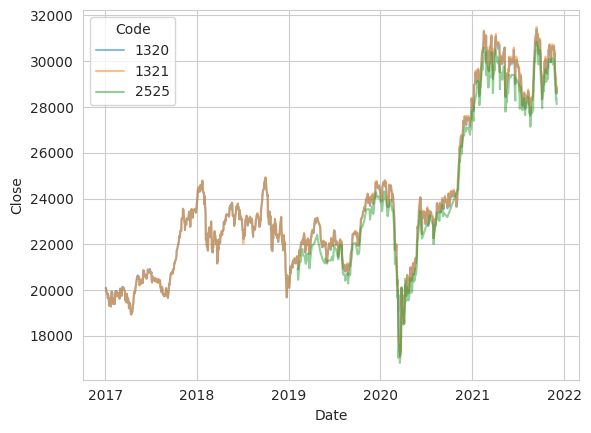

In [5]:
# a compilation of details about each security in the datasaet
# sec_stats = pd.read_csv(base_file_path+'stock_list.csv').rename({'SecuritiesCode':'Code'}, axis = 1).set_index('Code')

secondary_prices = pd.read_csv(base_file_path+'train_files/secondary_stock_prices.csv').rename({'SecuritiesCode':'Code'}, axis = 1)
secondary_prices.Date = pd.to_datetime(secondary_prices.Date)
secondary_prices = secondary_prices.set_index(['Code', 'Date']).sort_index()
nikkei_etfs = secondary_prices.loc[[1320, 1321, 2525]]

# remove the high memory 
del secondary_prices

fig, ax = plt.subplots()
sns.lineplot(nikkei_etfs, x = 'Date', y = 'Close', hue = 'Code', palette= 'tab10', alpha = 0.5)

In [6]:
# Merge the underlying stock data to the options dataframe
nikkei_etfs['UnderlyingClose'] = nikkei_etfs.Close
options = options.reset_index().merge(nikkei_etfs.loc[1320, 'UnderlyingClose'], how = 'left', on = 'Date')
options = options.set_index(['Date', 'Expiry', 'Putcall', 'StrikePrice']).sort_index()


* The green security seems to be the odd one out.  By inspection we'll just use security code1 320, Daiwa ETF-Nikkei 225.

# Contracts list
a compendium of trading activity for all the contracts in the dataset

In [7]:
# Useful groupby indices
indices = ['Date','Expiry', 'Putcall', ]

# A list of all the contracts in my dataset
contract_list = pd.DataFrame()

#aggregated trading volume (over all possible strikes) at a specific contract
contract_list['TotalVolume'] = options.groupby(indices)[['WholeDayVolume']].sum()

#Number of strike prices in a contract
contract_list['N_strikes']=options.reset_index('StrikePrice').groupby(indices)['StrikePrice'].nunique()


N_strikes = options.index.get_level_values('StrikePrice').unique().__len__()

# Filter contracts such that the whole day trading volume is greater than the number of strikes
contract_list = contract_list[contract_list.TotalVolume>1*N_strikes]

#rank the contracts by their volumes
contract_list['VolumeRank'] = contract_list['TotalVolume'].rank(ascending=False)
contract_list.sort_values(by = 'VolumeRank', inplace = True)


## Visualizing data

<Axes: xlabel='StrikePrice', ylabel='WholeDayVolume'>

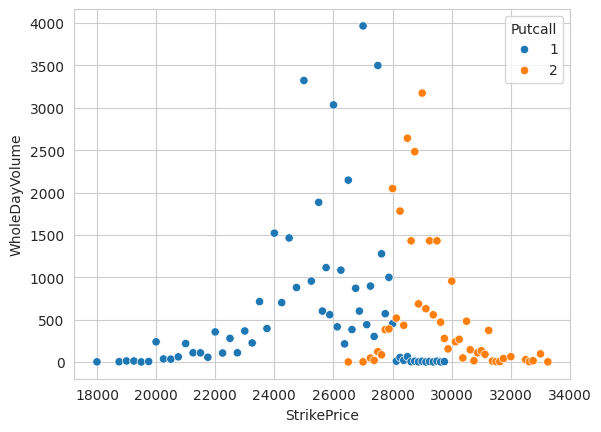

In [8]:
# Call and put close prices on a particular day for a particular expiry
fig, ax = plt.subplots()
# day = '2017-01-04'
day = '2021-12-03'
expiry = '2021-12-09'
df=options.loc[idx[day, expiry]]

sns.scatterplot(df, x='StrikePrice', y = 'WholeDayVolume', hue='Putcall', palette='tab10')

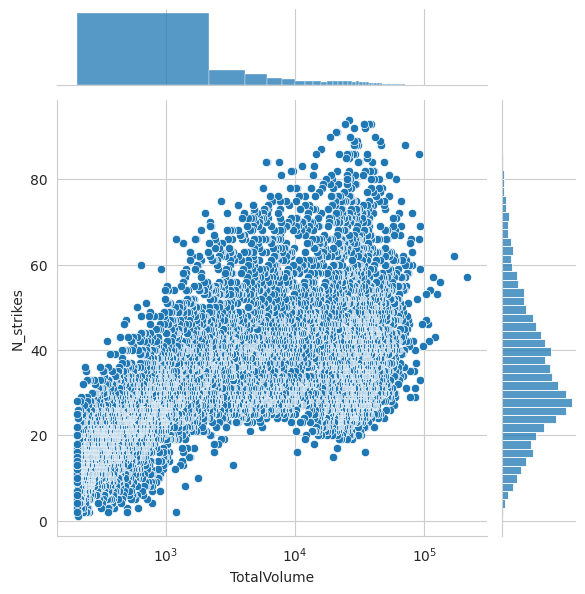

In [9]:
# fig, ax = plt.subplots(1, 2, figsize = (6.4*2, 4.8))

# sns.histplot(contract_list.N_strikes, ax=ax[0])
g=sns.jointplot(contract_list,y='N_strikes', x='TotalVolume')
g.ax_joint.set_xscale('log')

* A jointplot  of N_strikes v.s. TotalVolume suggests I should only consider securities that traded with at least 20 different strike prices. That would remove most of the low trading securities.

In [10]:
# Identify the contracts that have at least 20 strikes traded on a particular day
good_training_examples=contract_list[contract_list.N_strikes>=20].sort_index().index

# Exclude the training examples that are not considered "good"
options = options[options.index.droplevel(-1).isin(good_training_examples)].copy()


# Computing the implied probability distribution:
1. Calculate the butterfly spread premium and then smooth data with a gaussian kernel 
2. Smooth the pricing data with a savitzky-golay filter, calculate the CDF, and use Kolmogorov-Smirnov test to find family of distribution

# Butterfly spread approach

Below are 3 methods to compute the butterfly spread premiums, the fastest method is uncommented below


In [11]:

# Less than 0.1s runtime 

options['butterfly'] = SecondDerivative_pdgroupby(options['WholeDayClose'].groupby(indices, group_keys=False))

#4.4 seconds runtime
#options.groupby(indices, group_keys=False)['WholeDayClose'].apply(pandas_butterfly_contract)

#4.4 seconds runtime
# options.groupby(indices, group_keys=False)['WholeDayClose'].apply(lambda x: x.shift(1)+x.shift(-1)-2*x)

# calculate the derivative
options['dK'] = options.index.get_level_values('StrikePrice')
options['dK'] = options['dK'].groupby(['Date', 'Expiry', 'Putcall']).diff()
options['curvature'] = options.butterfly.div(options.dK.pow(2))

In [12]:
options['pdf'] = options.groupby(indices, group_keys=False)['curvature'].apply(
    GaussKernelSmoother_pandas, 5)

(Timestamp('2020-03-02 00:00:00'), Timestamp('2020-03-12 00:00:00'))
2.0


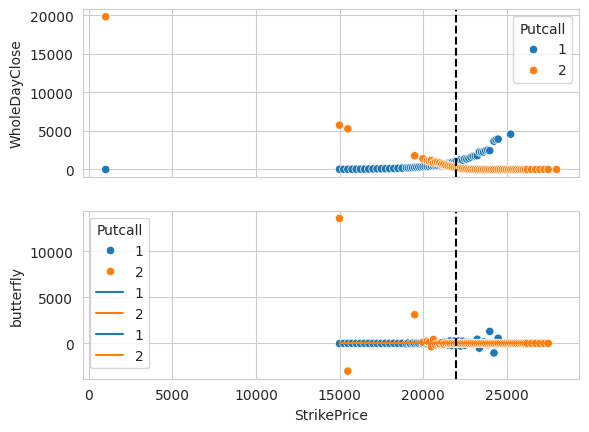

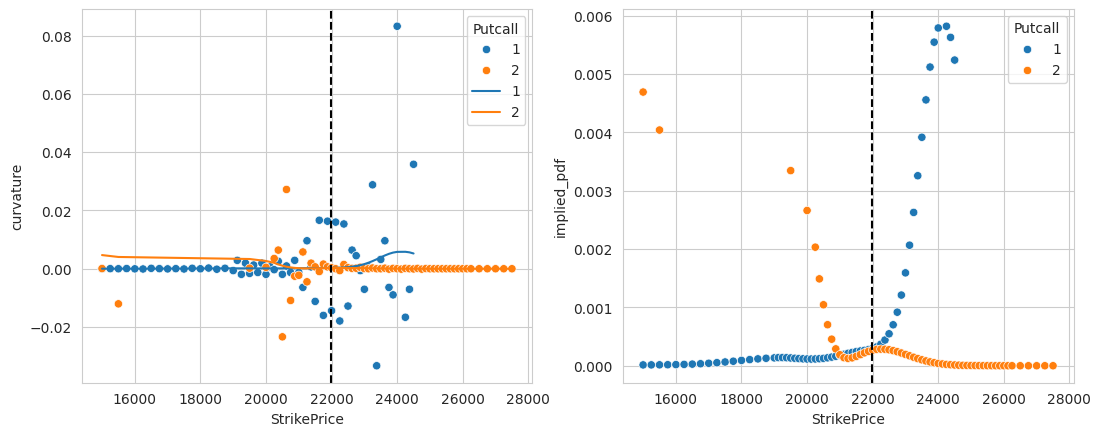

In [26]:
example_1 = contract_list.index[1]
print(example_1[:-1])
df_orig = options.loc[example_1[:-1]]
# df_orig = options.loc[idx[row, expiry]]

df=df_orig.copy()



print(df_orig.WholeDayVolume.quantile(0.05))
df['implied_pdf'] = GaussKernelSmoother_pandas(df.curvature, 5, order = 0)
fig, ax = plt.subplots(2, 1, figsize = (6.4, 4.8), sharex=True)

sns.scatterplot(df_orig, x = 'StrikePrice', y = 'WholeDayClose', ax=ax[0], hue ='Putcall', palette= 'tab10')
sns.scatterplot(df, x = 'StrikePrice', y = 'butterfly', ax=ax[1], hue='Putcall', palette= 'tab10')
sns.lineplot(df, x = 'StrikePrice', y = 'pdf', ax=ax[1], hue ='Putcall', palette= 'tab10')
sns.lineplot(df, x = 'StrikePrice', y = 'implied_pdf', ax=ax[1], color = 'tab:green', hue='Putcall', palette= 'tab10')

for a in ax: a.axvline(df['UnderlyingClose'].iloc[0], color = 'k', linestyle = '--')


fig,ax = plt.subplots(1,2, figsize = (6.4*2, 4.85))
# sns.scatterplot(df, x = 'StrikePrice', y = 'pdf', )
sns.scatterplot(df, x = 'StrikePrice', y = 'curvature',ax=ax[0], hue='Putcall', palette= 'tab10')
# sns.lineplot(df, x = 'StrikePrice', y = 'pdf', ax=ax[1], hue ='Putcall', palette= 'tab10')

sns.lineplot(df, x = 'StrikePrice', y = 'implied_pdf', color = 'tab:green', ax=ax[0], hue='Putcall', palette= 'tab10')

# sns.lineplot(df, x = 'StrikePrice', y = 'pdf', ax=ax[1], hue ='Putcall', palette= 'tab10')

sns.scatterplot(df, x='StrikePrice', y='implied_pdf', ax=ax[1], color='tab:green', hue='Putcall', palette= 'tab10')

for a in ax: a.axvline(df['UnderlyingClose'].iloc[0], color = 'k', linestyle = '--')


# Some thoughts:
Obvoiusly high probability of the price falling well below the underlying close is just erroneus (in the orange plot). Same goes for the price rising to 24k when the udnerlying is at 22k is also probably erroneus.

The wise thing to do might be to remove contracts that are trading far from the underlying.  Since it's an index, removing strikes that are more $\pm$ 10% from the underlying close seems reasonable.

# Kolmogorov-Smirnov goodness of fit testing
Try and use goodness fit testing to find the family of distributions. 

In [17]:
options['close_smooth']=options.groupby(indices, group_keys=False).WholeDayClose.apply(savgol_pandas, 10, 1)
options['dirty_cdf'] = FirstDerivative_pdgroupby(options['WholeDayClose'].groupby(indices, group_keys=False))
options['implied_cdf'] = FirstDerivative_pdgroupby(options['close_smooth'].groupby(indices, group_keys=False)).div(options.dK)

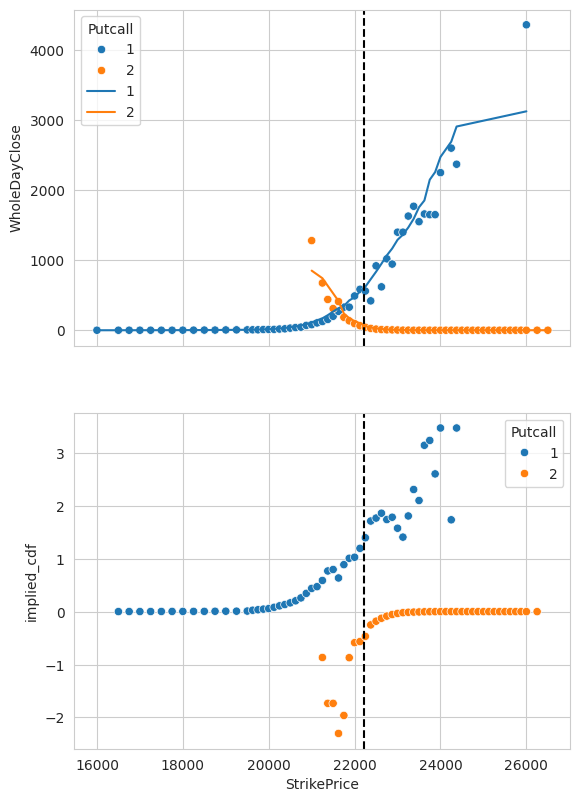

In [18]:
example_1 = contract_list.index[3]

df=options.loc[example_1[:-1]]



fig, ax = plt.subplots(2, 1, figsize = (6.4, 2*4.8), sharex=True)

sns.scatterplot(df, x = 'StrikePrice', y = 'WholeDayClose', ax=ax[0], hue ='Putcall', palette='tab10')
sns.lineplot(df, x = 'StrikePrice', y = 'close_smooth', ax=ax[0], hue ='Putcall', palette='tab10')

# sns.scatterplot(df, x = 'StrikePrice', y = 'dirty_cdf', ax=ax[1], hue ='Putcall', palette='tab10')
sns.scatterplot(df, x = 'StrikePrice', y = 'implied_cdf', ax=ax[1], hue ='Putcall', palette='tab10')

for a in ax: a.axvline(df['UnderlyingClose'].iloc[0], color = 'k', linestyle = '--')


# Some thougts and ideas to pick back up on
* Might be wise to remove extreme strikes, that are far from the underlying.
